## Project specification

Implement a standard echo state network (ESN) model as discussed in class. Do not include feedback from the output and do not use leaky-integrator neurons. Implement training of the read-out weights by means of ridge regression. Perform experiments and comment the results by considering a _k_ step ahead forecasting task on the "2sine" and "lorenz" time series data provided to you together with this notebook. Evaluate the impact of relevant hyper-parameters on the results, including the reservoir size and the amount of training data used for optimizing the read-out weights. Finally, discuss the effects of using different forecasting horizons on the overall performance of the model. **Note:** it is possible to consider the impact of additional hyperparameters, like the spectral radius of the reservoir matrix, and this will give you some extra points.

### K step ahead forecasting
A _k_ step ahead forecasting task consists of predicting the value of a time series at time $t+k$ by using the value of the time series at time $t$, where $k\geq1$ is called forecasting horizon.
In general, the predicted value is always unidimensional (i.e. a single number). However, it is possible to use multiple input values in order to improve the results. Notably, once _k_ is decided, the output to be predicted is the value of the time series at time $t+k$, and the input may be a vector containing values of the times series at time $t, t-1, \dots, t-n$, where $n\geq0$ is defined by the user and sets the dimensionality of the input vector.

## Your project starts from here!

In [41]:
import numpy as np
import matplotlib.pyplot as plt

## Activation Function
The activation function used when calculating the state at time-step 't' is the Sigmoid function.

It is implemented below according to the following formula:

$\sigma(x) = \frac{1}{(1 + e^{-x})}$

In [42]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Ridge Regression
Once the states up to the end of the training data are calculated, *Ridge Regression* is used to find the optimized weights, *w_o*.

Ridge Regression is implemented below according to the following formula:
$(X^{T}X + \alpha I)^{-1}X^{T}t$
Where $X$ is the state matrix (*training_state*), and
$\alpha$ is the regularization variable (*alpha*), and
$I$ is the identity matrix with dimensions $Nr * Nr$ (*res_size* by *res_size*), and
$t$ is the vector of targets.

In [43]:
def ridge_regression(training_state, res_size, alpha, targets):
    return np.array(
        [np.dot(np.dot(np.linalg.inv(np.dot(training_state.T, training_state) + (alpha * np.identity(res_size))),
                       training_state.T), targets)])

## Calculating State
The state of the ESN is required for training, and making predictions.

The formula for calculating state at time-step 't' is implemented below according to the following formula:
$X_t = \sigma(W_r X_{t - 1} + W_i u_t)$
Where $X_t$ is the state at time-step $t$, and
$X_{t - 1}$ is the previous state (*prev_state*), and
$W_r$ and $W_i$ are the weight matrices (*weigh_r* and *weigh_i* respectively), and
$u_t$ is the data at time-step $t$, and
$\sigma(  )$ is the activation function (the *sigmoid* function in code)

In [44]:
def calc_state(u_t, prev_state, weigh_r, weigh_i):
    x_t1 = np.dot(weigh_r, np.array([prev_state]).T)
    x_t2 = np.dot(weigh_i, u_t)
    deact_x_t = x_t1 + x_t2
    x_t = sigmoid(deact_x_t)
    return x_t

## Calculating State for the training data
The following function loops through all the training data and calculates the state at each time-step. It then adds that state to the matrix of all states, before returning all states for use with *Ridge Regression*.

In [45]:
def calc_train_state(data, res_size, train_size, weigh_r, weigh_i):
    # initial state of 1 x res_size array full of 0's
    state = np.zeros((res_size, 1)).T
    # calc state up to timestep t
    # print(train_size, data.size, res_size)
    for t in range(1, train_size):
        x_t = calc_state(data[t - 1], state[t - 1], weigh_r, weigh_i)
        state = np.concatenate((state, x_t.T), axis=0)
    return state

## Calculating Mean Squared Error
The following function gets the *1-Step Ahead Prediction* using the vector *data* as input.
It then uses the predictions and the *data* vector to calculate the *Mean Squared Error* of the predictions.

The *Mean Squared Error* is implemented according to the following function:
$\frac{1}{s}\sum(p_i - d_i)^{2}, p_i \epsilon P, d_i \epsilon D$
Where $P$ is the vector of predictions (*pred*), and
$D$ is the vector of target data (*data*) corresponding to the predictions in $P$, and
$p_i$ is the $i^{th}$ entry in the $P$ vector, and
$d_i$ is the $i^{th}$ entry in the $D$ vector, and
$s$ is the size of both of the $P$ and $D$ vectors (*size*).

In [46]:
def mse(w_o, size, data, res_size, weigh_r, weigh_i, k):
    pred = k_step(size, k, data, res_size, weigh_r, weigh_i, w_o)
    return (np.sum((pred - data) ** 2)) / size

## K-Step Ahead Forecasting
This function implements the prediction function, and uses it to perform *K-Step Ahead Forecasting*.

The prediction function is defined as follows:
$Z_t = W_o X_t$
Where $Z_t$ is the prediction at time-step $t$, and
$W_o$ is the weights optimized through *Ridge Regression*, and
$X_t$ is the state at time-step $t$ (*state[j + 1]*)

This function creates a list of all the *K-Step Ahead Forecasts* that can be created using the testing/cross-validation data(*data*).
That is to say, this function calculates $Z_{t+k}$ for all possible $t$ in the set *data*.

The general flow of the function is as follows:

For all possible $t$ in the set *data*
1. Create initial null state matrix *state*
2. Grab the data $u_t$ from *data[t]*
3. Calculate $X_t$ using null state matrix, and add it to the end of the state matrix
4. Predict $Z_t$ using $X_t$ and the prediction formula
5. Use $Z_t$ as the input for calculating the next state $X_{t + 1}$
6. Predict $Z_{t+1}$ using $X_{t+1}$...
7. Repeat until $Z_{t+k}$ has been predicted, and add $Z_{t+k}$ to *predictions* list


Once all $Z_{t+k}$ have been added to *predictions*, return *predictions*



In [47]:
def k_step(pred_len, k, data, res_size, weigh_r, weigh_i, w_o):
    # print(pred_len, k, res_size, data.size)
    predictions = np.zeros(pred_len-k)
    for i in range(0, pred_len-k):
        # every prediction, start with empty state
        state = np.zeros((res_size, 1)).T
        # grab the input from data
        u_t = data[i]
        # print(i, ": ", u_t)
        # calculate state to predict k-steps ahead of
        x_t = calc_state(u_t, state[0], weigh_r, weigh_i)
        state = np.concatenate((state, x_t.T), axis=0)
        for j in range(0, k):
            z_t = np.dot(w_o, np.array(state[j + 1]).T)
            if j == k - 1:
                # z_t is k-steps ahead prediction,
                # no need to loop anymore, store it and break
                predictions[i] = z_t
                break
            # calc next state using prediction as input
            x_t = calc_state(z_t, state[j + 1], weigh_r, weigh_i)
            state = np.concatenate((state, x_t.T), axis=0)
    return predictions

## Echo State Network
This is the main function of the echo state network, calling this function will create an instance of an echo state network according to the given parameters.

The ESN function is designed to be a helper function for optimizing hyper-parameters, but it is also can work as a standalone function.

The ESN takes 7 inputs:
1. filename: The name of the file where the data resides as a string
2. alpha: The regularization variable for use with *Ridge Regression*
3. res_size: The reservoir size, AKA $Nr$
4. tr_size: The percentage of data that is used for training
5. te_size: The percentage of data that is used for testing (is *0* for cross-validation)
6. k: The number of steps taken for *K-Step Ahead Forecasting*
7. c_size: The percentage of the data that is used for cross-validation

The ESN function's behaviour changes depending on the inputs

* If the test size is equal to *0*, then the echo state network will train itself on the training data, then find the *Mean Squared Error* of its *1-Step Ahead Forecasting* on the cross validation data, and then return the *Mean Squared Error*. This is used to perform a basic search in the hyper-parameter space to find the optimal hyper-parameters; the ones with the lowest *Mean Squared Error*


* If the test size isn't equal to *0*, then the echo state network first output a graph of the input data, then it will train itself on the training data, and then perform *K-Step Ahead Forecasting* on the testing data. Once it's finished with the forecasting, the function will output a graph of predicted and actual data values along with printing out the *Mean Squared Error* of the predictions.


In addition, the ESN function generates $W_r$ (*weigh_r*) and $W_i$ (*weigh_i*) from a [-1,1] uniform distribution into ($Nr$, $Nr$) and ($Nr$, $1$) matrices respectively.


In [48]:
def ESN(filename: str, alpha, res_size, tr_size, te_size, k, c_size):
    # Load the data from the file
    data = np.loadtxt(filename)

    # convert data sizes from percentages to actual numbers
    train_size = int(np.floor(data.size * tr_size / 100))
    cross_size = int(np.floor(data.size * c_size / 100))
    test_size = int(np.floor(data.size * te_size / 100))

    # plot the data
    if test_size != 0:
        print("Loaded data of size: ", data.size)
        print("Training data amount: ", train_size, "\nTest data amount: ", test_size, "\nReservoir size: ", res_size)
        plt.figure(1).clear()
        plt.title('Input Data')
        plt.plot(data)
        plt.show()
    # keep seed consistent for testing
    np.random.seed(69)
    in_dim = 1
    out_dim = 1
    # randomly select w_i and w_r from a [-1,1] uniform distribution
    weigh_i = np.random.uniform(-1, 1, (res_size, in_dim))
    weigh_r = np.random.uniform(-1, 1, (res_size, res_size))
    MSE = -1

    # calculate the state matrix for the training data
    state = calc_train_state(data, res_size, train_size, weigh_r, weigh_i)
    # calculate the optimized weights using the state matrix
    w_o = ridge_regression(state, res_size, alpha, data[:train_size])

    if test_size != 0:  # yes testing
        # run model on testing data (shift by cross_size)

        predictions = k_step(test_size - k, k, data[train_size + cross_size:train_size + cross_size + test_size - k],
                             res_size, weigh_r, weigh_i, w_o)

        MSE = mse(w_o, test_size, data[train_size + cross_size:train_size + cross_size + test_size - k], res_size, weigh_r, weigh_i, k)
        # MSE = (np.sum((predictions - data[train_size + cross_size:train_size + cross_size + test_size - k]) ** 2)) / test_size

        # print(predictions)
        plt.figure(2).clear()
        plt.title("Predicted values for testing data")
        plt.plot(predictions, label="Predicted", color="red")
        plt.plot(data[train_size + cross_size:train_size + cross_size + test_size - k], label="Actual", color="blue")
        plt.legend()
        plt.show()
        print("The MSE for ", k, "-Step Ahead Forecasting is: ", MSE)
    else:  # cross-validation
        # predict on cross-validation data
        # and then return mean squared error of said predictions/data
        MSE = mse(w_o, cross_size, data[train_size: train_size + cross_size - k], res_size, weigh_r, weigh_i, k)

    return MSE


## Optimizing Hyper-Parameters
The following function calls the two helper functions *optimize_nr* and *optimize_alpha* to optimize the hyper-parameters $Nr$ and $\alpha$. After the hyper-parameters have been optimized, this function will create a new instance of the ESN for testing using the optimized hyper-parameters.

*optimize_hyperparams* takes 11 inputs:
1. filename: The name of the file where the data resides as a string
2. train_size: The percentage of data that is used for training
3. cross_size: The percentage of data that is used for cross-validation
4. k: The number of steps ahead the network will need to predict
5. pl_alph: A placeholder value for $\alpha$ for use when optimizing $Nr$
6. nr_sta: The lowest value for $Nr$ that will be used in cross-validation
7. nr_ste: The size of the increase of $Nr$ between each cross-validation
8. nr_len: The number of different times cross-validation will be performed on $Nr$
9. alp_sta: The lowest value for $\alpha$ that will be used in cross-validation
10. alp_ste: The size of the increase of $\alpha$ between each cross-validation
11. alp_len: The number of different times cross-validation will be performed on $\alpha$

The behaviour of this function could be described as searching through the hyper-parameter space, though not necessarily in the way expected. Since this function searches for $Nr$, and then uses the found $Nr$ to find $\alpha$, this is can be likened to a search through two 1D spaces sequentially.
First the function calls *optimize_nr* and moves through the hyper-parameter space from (*pl_alph*, *nr_sta*) to (*pl_alph*, *optimal_nr*), then the function calls *optimize_alph* and moves through the hyper-parameter space from (*pl_alph*, *optimal_nr*) to (*optimal_alph*, *optimal_nr*).
This finds the minimum MSE on the horizontal line y = *optimal_nr* in the range [*alp_sta*, *alp_sta* + (*alp_ste* * *alp_len*)].
While this is a minima, it is still only a local minima, as such *optimize_hyperparams* can be called multiple times, using the previous optimal values as the placeholder/starting values for the search to iteratively approach better hyper-parameters. This method of learning the optimal hyper-parameters is theoretically similar to gradient descent; they both iteratively approach a 'better' minima (lower error).

In [53]:
def optimize_hyperparams(filename: str, train_size, cross_size, k: int, pl_alph, nr_sta: int, nr_ste: int, nr_len: int, alp_sta, alp_ste, alp_len: int):
    print("Calculating optimal Nr, with a placeholder alpha of '", pl_alph, "'")
    nr = optimize_nr(filename, train_size, k, cross_size, nr_sta, nr_len, nr_ste, pl_alph)
    print("Optimal Nr: ", nr, "\n")
    alpha = optimize_alph(filename, train_size, k, cross_size, alp_sta, alp_len, alp_ste, nr)
    print("Optimal alpha: ", alpha, "\n")

    # data not used in training or cross-valid is testing data
    test_size = 100 - train_size - cross_size

    ESN(filename, alpha, nr, train_size, test_size, k, cross_size)

## Optimizing $Nr$
This function performs cross-validation on the data set given by *filename*. It loops *res_count* times, starting with an $Nr$ of *res_start*,increasing $Nr$ by *res_step* each loop. Each loop the function will create an ESN using the defined hyper-parameters, and get the *Mean Squared Error* from performing *K-Step Ahead Forecasting* on the cross-validation data and store it in the *errors* list. While looping, the function will keep track of *optimal_nr*, which is the $Nr$ that results in the lowest *Mean Square Error*. Once the loop is complete the function will graph the *MSE* vs $Nr$ and return the *optimal_nr*.

Alternatively, the function *optimize_nr* could be described as an iterative search through 1D "$Nr$" space

In [50]:
def optimize_nr(filename: str, train_size, k, cross_size, res_start, res_count, res_step, pl_alph):
    errors = np.zeros(res_count)
    nrs = np.zeros(res_count)
    lowest_mse = np.inf
    optimal_nr = -1
    # calculate mean square error for res_count different hyper-parameters
    for i in range(0, res_count):
        # errors[i - 1] contains MSE of ESN with a Nr of (res_start + (i * res_step))
        errors[i - 1] = ESN(filename, pl_alph, (res_start + (i * res_step)), train_size, 0, k, cross_size)
        nrs[i - 1] = (res_start + (i * res_step))
        if errors[i - 1] < lowest_mse:
            lowest_mse = errors[i - 1]
            optimal_nr = (res_start + (i * res_step))
            print("New lowest MSE of ", lowest_mse, " and an Nr of ", optimal_nr)
    assert optimal_nr != -1
    # graph the results
    plt.figure(11).clear()
    plt.title("MSE vs Nr")
    plt.scatter(x=nrs, y=errors)
    plt.xlabel("Nr")
    plt.ylabel("MSE")
    plt.show()
    return optimal_nr


## Optimizing $\alpha$
This function performs cross-validation on the data set given by *filename*. It loops *alph_count* times, starting with an $\alpha$ of *alph_start*,increasing $\alpha$ by *alph_step* each loop. Each loop the function will create an ESN using the defined hyper-parameters, and get the *Mean Squared Error* from performing *K-Step Ahead Forecasting* on the cross-validation data and store it in the *errors* list. While looping, the function will keep track of *optimal_alph*, which is the $\alpha$ that results in the lowest *Mean Square Error*. Once the loop is complete the function will graph the *MSE* vs $\alpha$ and return the *optimal_alph*.

Alternatively, the function *optimize_alph* could be described as an iterative search through 1D "$\alpha$" space

In [51]:
def optimize_alph(filename: str, train_size, k, cross_size, alph_start, alph_count, alph_step, res_size):
    errors = np.zeros(alph_count)
    alphas = np.zeros(alph_count)
    lowest_mse = np.inf
    optimal_alph = -1
    # calculate mean square error for res_count different hyper-parameters
    for i in range(0, alph_count):
        # errors[i - 1] contains MSE of ESN with a Nr of (res_start + (i * res_step))
        errors[i - 1] = ESN(filename, (alph_start + (i * alph_step)), res_size, train_size, 0, k, cross_size)
        alphas[i - 1] = (alph_start + (i * alph_step))
        if errors[i - 1] < lowest_mse:
            lowest_mse = errors[i - 1]
            optimal_alph = (alph_start + (i * alph_step))
            print("New lowest MSE of ", lowest_mse, " and an alpha of ", optimal_alph)
    assert optimal_alph != -1
    # graph the results
    plt.figure(12).clear()
    plt.title("MSE vs alpha")
    plt.scatter(x=alphas, y=errors)
    plt.xlabel("Alpha")
    plt.ylabel("MSE")
    plt.show()
    return optimal_alph


# 2Sin
This is the Echo State Network that makes use of the *2sin.txt* file.
In this section I will be comparing and contrasting the differences between *K-Step Ahead Forecasting* when using $k = 1,2,3$, and trying to rationalize the differences in terms of k, and the hyper-parameters used in the models.


<hr/>

## 2Sin using 1-Step Ahead Forecasting

Calculating optimal Nr, with a placeholder alpha of ' 0.01 '
New lowest MSE of  0.11439200949022296  and an Nr of  2
New lowest MSE of  0.0067955773019308975  and an Nr of  4


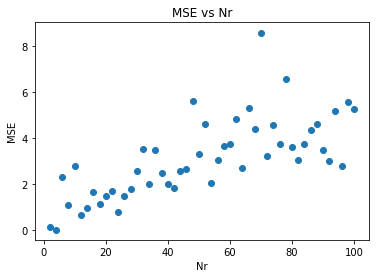

Optimal Nr:  4 

New lowest MSE of  0.0067955773019308975  and an alpha of  0.01
New lowest MSE of  0.005771979320711163  and an alpha of  0.21000000000000002
New lowest MSE of  0.003125232168024653  and an alpha of  0.23
New lowest MSE of  0.0017912773943214411  and an alpha of  0.25
New lowest MSE of  0.001597317332092079  and an alpha of  0.27


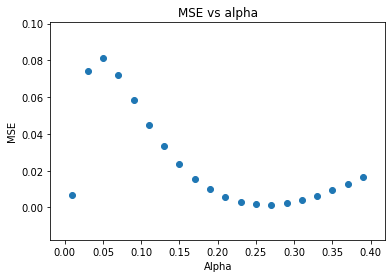

Optimal alpha:  0.27 

Loaded data of size:  2000
Training data amount:  1000 
Test data amount:  200 
Reservoir size:  4


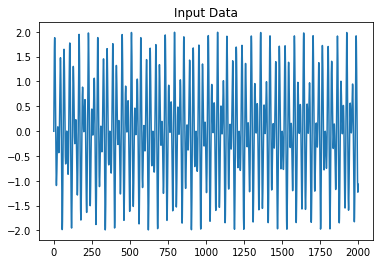

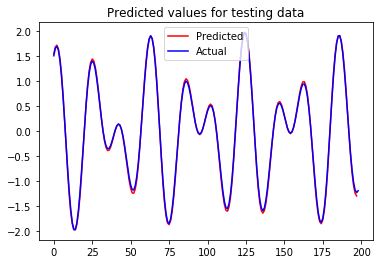

The MSE for  1 -Step Ahead Forecasting is:  0.0015958392139848615


In [107]:
optimize_hyperparams("2sin.txt", 50, 40, 1, 0.01, 2, 2, 50, 0.01, 0.02, 20)

As you can see, the Echo State Network is very good at *1-Step Ahead Forecasting*, with an extremely low *Mean Squared Error* of $~0.0016$.
The graph for *MSE* vs $Nr$ has a positive correlation, showing that as the model gets more complex ($Nr$ increases), the *Mean Squared Error* also increases. The graph for *MSE* vs $\alpha$ shows an immediate increase in *Mean Squared Error*, followed by a decently steep decrease in *MSE* until it reaches the minimum of $\alpha = 0.27$, before beginning to slowly increase.

The strong positive correlation of the $Nr$ graph, the 'bowl' shape of the $\alpha$ graph, and the extremely low *MSE* when testing tells me that the hyper-parameters, $Nr = 4$ and $\alpha = 0.27$ are a global minima in the hyper-parameter space, or at least, very close to the global minima.

The split of training/cross-validation/testing data was decided by giving half the data for training, and splitting the rest equally, resulting in a 50/25/25 split. When this worked well, I shifted some testing data over to the cross-validation data to get an easier to read testing graph, resulting in a 50/40/10 split.

<hr/>


## 2Sin using 2-Step Ahead Forecasting


Calculating optimal Nr, with a placeholder alpha of ' 1e-05 '
New lowest MSE of  1.5533505947810795  and an Nr of  2
New lowest MSE of  0.30497152571850294  and an Nr of  4


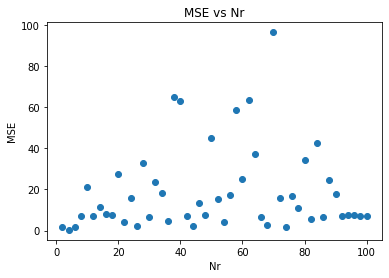

Optimal Nr:  4 

New lowest MSE of  0.30497152571850294  and an alpha of  1e-05


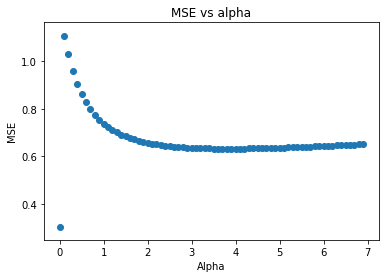

Optimal alpha:  1e-05 

Loaded data of size:  2000
Training data amount:  800 
Test data amount:  200 
Reservoir size:  4


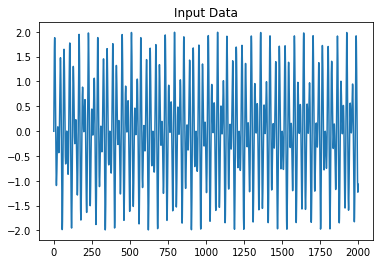

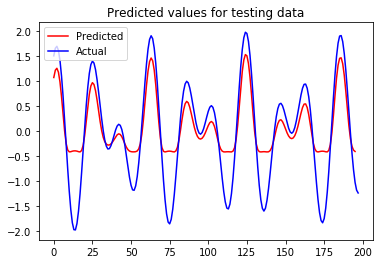

The MSE for  2 -Step Ahead Forecasting is:  0.33481558207212614


In [124]:
optimize_hyperparams("2sin.txt", 40, 50, 2, 1e-5, 2, 2, 50, 1e-5, 0.1, 70)

The Echo State Network is much worse at performing *2-Step Ahead Forecasting*, with a *Mean Squared Error* of ~$0.334$ (around $200$ times worse than *1-Step Ahead*). We can see in the *MSE* vs $Nr$ graph that the correlation between *MSE* and $Nr$ is still there, just much closer to zero than it was for *1-Step Forecasting*. In addition, the *MSE* vs $\alpha$ graph shows a similar 'bowl' shape to the graph for *1-Step Forecasting*, however, the increase at the start is much steeper, and the 'bowl' part of the graph is much wider, having a shallower increase from the lowest point in the 'bowl'. Unlike the $\alpha$ for *1-Step Forecasting*, the $\alpha$ in *2-Step Forecasting* is the initial value, instead of the value at the lowest point in the 'bowl', resulting in an $\alpha = 0.00001$.


The training/cross-validation/testing data split was the same as for *1-Step Ahead Forecasting* (50/40/10). I did tried both a 60/30/10 and a 40/50/10 split and found that while the 60/30/10 split increased *MSE* for the model, a 40/50/10 split decreased the *MSE* slightly (from *MSE* = ~$0.339$ to *MSE* = ~$0.334$), however any less training data than 40% increased the *MSE*.


A couple interesting things to note are:

* The closer $\alpha$ is to zero, the better it seems to do, though the changes in *MSE* are minimal (staying around ~$0.3$). However entering an $\alpha$, *pl_alph* of 1e-8, and having the *alp_ste* around the same range turns the *MSE* vs $\alpha$ graph into a small vertical looking line that is impossible to draw any conclusions from. There should be a way to dynamically change the scale of the pyplot graphs based on the data, but I'm unsure of how to do that, and the difference of *MSE* between $\alpha$ of 1e-8 and 1e-5 are minimal enough that I'm not willing to bother.

* There seems to be some kind of horizontal asymptote just above $ y = -0.5$ in the testing graph, and I'm not sure why that is. If it's because my model is not complex enough, then I should be getting an $Nr$ higher than 4, but the slight positive correlation between *MSE* and $Nr$ makes that unlikely. If it's because my model is too complex, then the model should be showing lower *MSE* for higher $\alpha$, but the model shows lower *MSE* the closer $\alpha$ is to zero, as mentioned above. Additionally, the percentage of training data my model uses seems to be the best it can be. The fact that both of my hyper-parameters and my training data seem to be 'optimal', yet my model doesn't seem to fit as well as it should points to the possibility of being stuck in a local minima in my hyper-parameter space, or that this is some quirk of *K-Step Ahead Forecasting*.

<hr/>

## 2Sin using 3-Step Ahead Forecasting

Calculating optimal Nr, with a placeholder alpha of ' 1e-05 '
New lowest MSE of  1.1144270248193036  and an Nr of  2
New lowest MSE of  0.41675741784304504  and an Nr of  14
New lowest MSE of  0.17082880486137716  and an Nr of  34


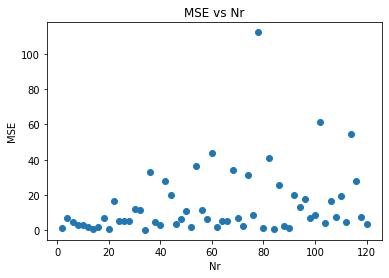

Optimal Nr:  34 

New lowest MSE of  0.17082880486137716  and an alpha of  1e-05


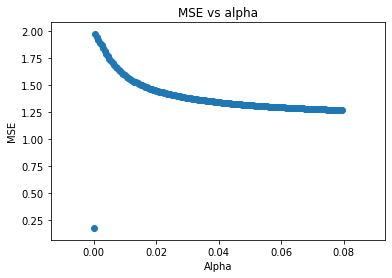

Optimal alpha:  1e-05 

Loaded data of size:  2000
Training data amount:  600 
Test data amount:  200 
Reservoir size:  34


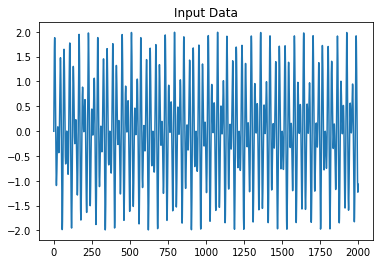

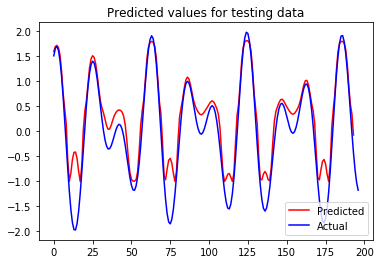

The MSE for  3 -Step Ahead Forecasting is:  0.16493322370195948


In [130]:
optimize_hyperparams("2sin.txt", 30, 60, 3, 0.00001, 2, 2, 60, 0.00001, 0.0005, 160)

This model works better than *2-Step Ahead Forecasting*, but still ~$100$ times worse than *1-Step Ahead Forecasting*, having a *MSE* of ~$0.165$, which is unexpected. What is expected, however, is the results of the *MSE* graphs. The *MSE* vs $Nr$ graph shows an even lower positive correlation between *MSE* and $Nr$, practically zero at this point. The *MSE* vs $\alpha$ graph also changed from it's *2-Step* counterpart, with a much steeper initial incline, increasing from ~$0.165$ to ~$2$ almost instantly.

It is interesting to note that the optimal $Nr$ is much higher, $34$ instead of the $4$ that was used for *1-Step* and *2-Step* forecasting. The higher $Nr$ makes this model much more complex than the previous models, especially considering that the regularization variable, $\alpha$, is the same as it was for *2-Step Forecasting*. However, despite the increase in complexity, this model generalizes better than the *2-Step Ahead* model, which is confusing. This leads me to believe that my *2-Step* model was stuck in a local minima, most likely for $\alpha$, however based on my other tests with larger $\alpha$s, the local minima that my model is in seems to work the best compared to all the alternatives I tried.

Another interesting thing to note is the existence of a horizontal asymptote like in the *2-Step* model. However, instead of flattening out, this model seems to create an extra 'bump' in the part that was flat for *2-Step*. I believe this is because of the increased complexity present in the *3-Step* model compared to the other models, increasing the degree of the function mapping the inputs to the predictions.

# Lorenz
This is the Echo State Network that makes use of the *lorenz.txt* file.
In this section I will be comparing and contrasting the differences between *K-Step Ahead Forecasting* when using $k = 1,2,3$, and trying to rationalize the differences in terms of k, and the hyper-parameters used in the models.

<hr/>

## Lorenz Using 1-Step Ahead Forecasting


Calculating optimal Nr, with a placeholder alpha of ' 0.2 '
New lowest MSE of  8.324235618599639  and an Nr of  2
New lowest MSE of  2.3334170294249357  and an Nr of  4


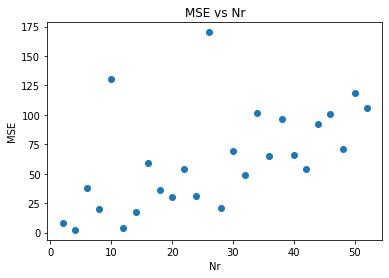

Optimal Nr:  4 

New lowest MSE of  2.3334170294249357  and an alpha of  0.2
New lowest MSE of  2.083018546319187  and an alpha of  0.4
New lowest MSE of  2.0280493173875005  and an alpha of  0.6000000000000001


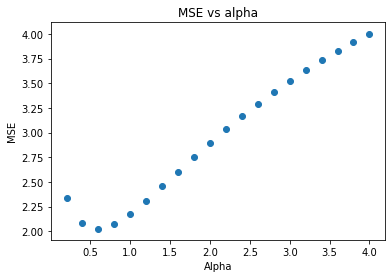

Optimal alpha:  0.6000000000000001 

Loaded data of size:  16384
Training data amount:  6553 
Test data amount:  6553 
Reservoir size:  4


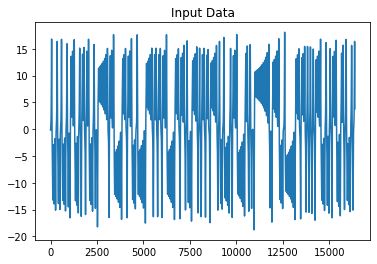

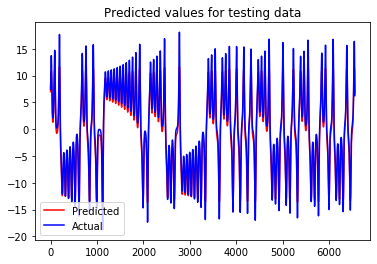

The MSE for  1 -Step Ahead Forecasting is:  2.0286598950307453


In [154]:
optimize_hyperparams("lorenz.txt", 40, 20, 1, 0.2, 2, 2, 26, 0.2, 0.2, 20)

Similar to the 2Sin *1-Step* model, the Lorenz *1-Step* model generalizes very well, though not as well as the 2Sin model. This model also has a strong positive correlation between *MSE* and $Nr$, and it's *MSE* vs $\alpha$ graph clearly shows a minima for $\alpha$ at 0.6. It should be noted, however, that all the local maxima and minima in the model seem to be much lower/higher respectively compared to what was expected. This could be because the model isn't complex enough, having only $4$ for $Nr$, the same number as the *1-Step* 2Sin model, despite the Lorenz data's arguably higher complexity. Though, the positive correlation between *MSE* and $Nr$, and the obvious minima in the $\alpha$ graph make me unsure how the function could get more complex without causing it to fail to generalize. It's entirely possible that the error produced in the predictions is just due to the Lorenz data being inherently hard to model, which it is compared to 2Sin.

The training/cross-validation/testing split was chosen to be the same as the *1-Step Ahead Forecasting* model's split initially (50/40/10). However the larger data set increasing model optimizing times, and the minimal increase in *MSE* led me to switching the split to 40/20/40.

<hr/>

## Lorenz Using 2-Step Ahead Forecasting

Calculating optimal Nr, with a placeholder alpha of ' 0 '
New lowest MSE of  66.73530125520308  and an Nr of  2
New lowest MSE of  41.0145510958645  and an Nr of  4


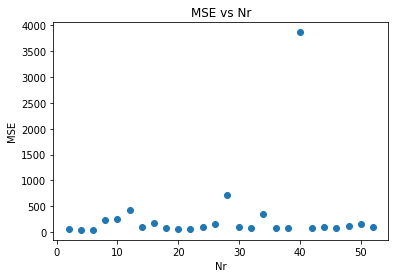

Optimal Nr:  4 

New lowest MSE of  41.0145510958645  and an alpha of  0.0


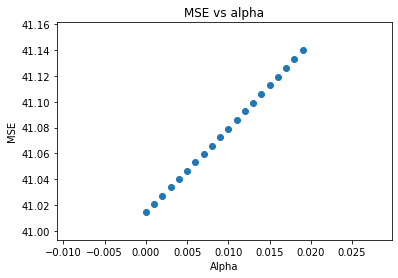

Optimal alpha:  0.0 

Loaded data of size:  16384
Training data amount:  6553 
Test data amount:  6553 
Reservoir size:  4


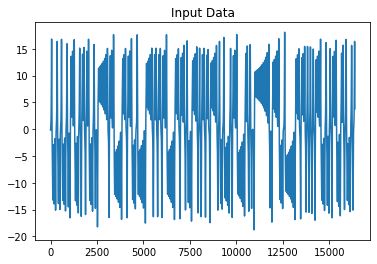

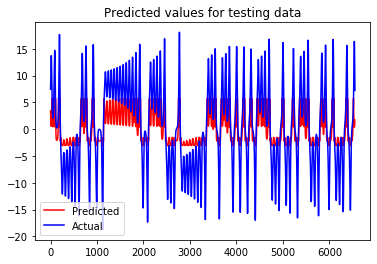

The MSE for  2 -Step Ahead Forecasting is:  40.49489992347079


In [155]:
optimize_hyperparams("lorenz.txt", 40, 20, 2, 0, 2, 2, 26, 0, 0.001, 20)

This model generalizes worse than the *1-Step Ahead* model, which is expected. What isn't expected is the rapid decrease in correlation between *MSE* and $Nr$, to the point at which the correlation might as well be zero. Additionally, the *MSE* vs $\alpha$ graph shows an almost linear increase in *MSE*. That in conjunction with the fact that $\alpha$ is zero lead me to believe that the current $\alpha$ is likely a local minima, instead of a global minima. Supporting this is the fact that right near the first maxima of the actual data, the predicted model is much more complex than it should be. What I find hard to understand, is how the *MSE* could get worse if $\alpha$ is increased, decreasing the model's over-complexity. Logically, as the regularization variable increases, the model should become less complex, and therefor generalize better, however the $\alpha$ graph seems to contradict that.

The training/cross-validation/testing split was kept the same as the split for the *1-Step* model.

<hr/>

## Lorenz Using 3-Step Ahead Forecasting

Calculating optimal Nr, with a placeholder alpha of ' 0.02 '
New lowest MSE of  60.25569055084736  and an Nr of  2
New lowest MSE of  53.19546176651375  and an Nr of  14
New lowest MSE of  48.955409541727285  and an Nr of  28
New lowest MSE of  45.637456599884466  and an Nr of  30


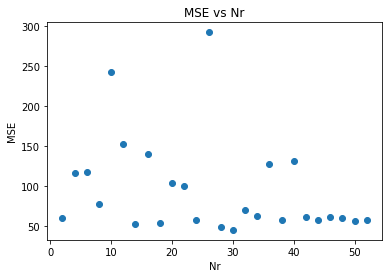

Optimal Nr:  30 

New lowest MSE of  45.637456599884466  and an alpha of  0.02
New lowest MSE of  44.820737335524605  and an alpha of  0.04


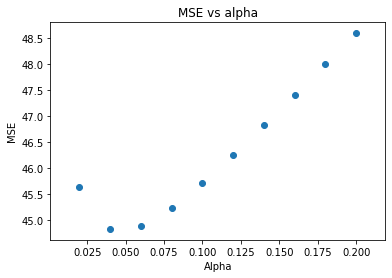

Optimal alpha:  0.04 

Loaded data of size:  16384
Training data amount:  6553 
Test data amount:  6553 
Reservoir size:  30


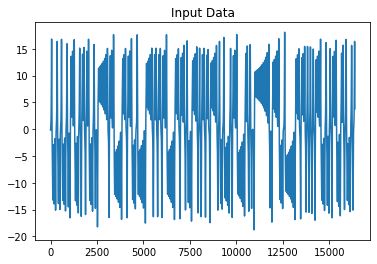

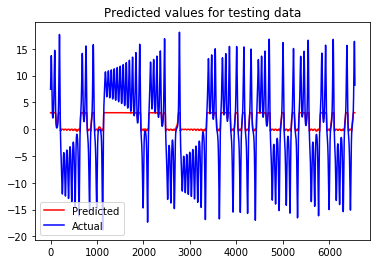

The MSE for  3 -Step Ahead Forecasting is:  46.06007342936922


In [156]:
optimize_hyperparams("lorenz.txt", 40, 20, 3, 0.02, 2, 2, 26, 0.02, 0.02, 10)

This model generalizes worse that the *2-Step* model, even more than the *MSE* would appear to imply. Compared to the *2-Step* model the *3-Step* model almost looks like a binary step function, which is much further from the target function compared to the *2-Step* model than a 7+ increase in *MSE* would suggest. While the *MSE* vs $\alpha$ graph looks normal compared to the *2-Step* model's, the *MSE* vs $Nr$ graph of this model looks like it has an extremely slight negative correlation. Additionally, this model seems to have two horizontal asymptotes, one at $y \approx 0$ and another at $y \approx 3$.

The training/cross-validation/testing split was kept the same as the split for the *1-Step* model.

## Conclusion
Overall, there are several conclusions that can be drawn from all of these models.

Firstly, as $k$ increases in *K-Step Ahead Forecasting* the correlation between *MSE* and $Nr$ seems to decrease, potentially becoming negative.

Secondly, *K-Step Ahead Forecasting*, in general, will provide better results the lower $k$ is. With the best results being provided when $k = 1$. This is because to predict $k$ steps ahead the current time-step, the network must predict all the steps between time-step $t$ and time-step $k$ to predict time-step $t + k$. This causes the error caused by the ESN to compound on itself, as each state calculation needs to use a prediction as the input $u_t$.

Thirdly, the difference between a local minima and global minima in hyper-parameter space can result in vastly different *Mean Squared Errors* as shown by 2Sin's *2-Step* and *3-Step* predictions.

Fourthly, if the comparison made between gradient descent and the hyper-parameter search in the description of my *optimize_hyperparams* function is correct, the addition of a gradient descent-like algorithm to optimize the weights (hyper-parameters) would likely result in better forecasts for all $k$.


